# Exploring Embeddings and Email Display Issues

This notebook investigates two issues:
1. Why only a small percentage of emails got embeddings via the Jina API
2. Why the Streamlit application is failing with the `Invalid height 16px for st.text_area` error

In [48]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Set up display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 100)

## 1. Load the Embeddings DataFrame

In [49]:
# Define the project and path
ACTIVE_PROJECT = "Projet Demo"
embeddings_path = os.path.join('data', "Projects", ACTIVE_PROJECT, 'emails_with_embeddings.pkl')

# Load the data
df = pd.read_pickle(embeddings_path)
print(f"DataFrame shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

DataFrame shape: (18978, 4)

Columns: ['message_id', 'body', 'original_body', 'embeddings']


In [66]:
# Check how many emails have embeddings
has_embeddings = df['embeddings'].notna()
embedding_count = has_embeddings.sum()
empty_count = (~has_embeddings).sum()

print(f"Emails with embeddings: {embedding_count} ({embedding_count/len(df):.2%})")
print(f"Emails without embeddings: {empty_count} ({empty_count/len(df):.2%})")

Emails with embeddings: 18 (0.09%)
Emails without embeddings: 18960 (99.91%)


## 2. Analyze Email Bodies and Empty Lines

In [51]:
# Function to count lines in a text
def count_lines(text):
    if pd.isna(text) or not isinstance(text, str):
        return 0
    return len(text.splitlines())

# Function to count empty lines
def count_empty_lines(text):
    if pd.isna(text) or not isinstance(text, str):
        return 0
    return sum(1 for line in text.splitlines() if not line.strip())

# Function to calculate text length
def text_length(text):
    if pd.isna(text) or not isinstance(text, str):
        return 0
    return len(text)

# Calculate statistics for all emails
df['line_count'] = df['body'].apply(count_lines)
df['empty_line_count'] = df['body'].apply(count_empty_lines)
df['non_empty_line_count'] = df['line_count'] - df['empty_line_count']
df['text_length'] = df['body'].apply(text_length)

In [52]:
# Look at statistics for emails with vs without embeddings
emails_with_embeddings = df[has_embeddings]
emails_without_embeddings = df[~has_embeddings]

print("Statistics for emails WITH embeddings:")
print(emails_with_embeddings[['line_count', 'empty_line_count', 'non_empty_line_count', 'text_length']].describe())

print("\nStatistics for emails WITHOUT embeddings:")
print(emails_without_embeddings[['line_count', 'empty_line_count', 'non_empty_line_count', 'text_length']].describe())

Statistics for emails WITH embeddings:
       line_count  empty_line_count  non_empty_line_count  text_length
count        18.0              18.0                  18.0    18.000000
mean          1.0               0.0                   1.0  1360.111111
std           0.0               0.0                   0.0  2638.934921
min           1.0               0.0                   1.0     6.000000
25%           1.0               0.0                   1.0    55.500000
50%           1.0               0.0                   1.0   201.000000
75%           1.0               0.0                   1.0   595.750000
max           1.0               0.0                   1.0  7976.000000

Statistics for emails WITHOUT embeddings:
       line_count  empty_line_count  non_empty_line_count   text_length
count     18960.0           18960.0               18960.0  18960.000000
mean          1.0               0.0                   1.0    513.185549
std           0.0               0.0                   0.0    83

In [67]:
# Check for emails with very few lines (potential issue with Streamlit height)
very_short_emails = df[df['line_count'] == 1]
print(f"Number of emails with only 1 line: {len(very_short_emails)}")

# Display some examples of very short emails
print("\nSample of emails with only 1 line:")
for i, (idx, row) in enumerate(very_short_emails.iloc[:5].iterrows()):
    print(f"\nEmail {i+1} (length: {len(row['body'])}):\n{row['body']}")

Number of emails with only 1 line: 18978

Sample of emails with only 1 line:

Email 1 (length: 126):
Bonjour, Je vous remercie pour ce complément d'informations. Nous nous réjouissons d'avance de cette participation à cette tab

Email 2 (length: 116):
Bonjour Céline, l’AAF a-t-elle prévu de faire un communiqué de presse sur l’attentat de vendredi ? Amicalement Agnés

Email 3 (length: 198):
Bonjour Céline et merci beaucoup !Ce sera un plaisir de vous retrouver, en effet. Bien cordialement, Louis GermainDirecteur généralT. 418 652-2357louis.germain@archivistes.qc.cawww.archivistes.qc.ca

Email 4 (length: 1261):
Bonjour, C'est avec plaisir que nous vous compterons parmi nous pour le prochain congrès de l'AAQ. La table-ronde à laquelle vous êtes conviés, Archives de la quarantaine a été programmée le vendredi 28 mai à 08h30, heure du Québec.75 minutes sont prévues pour la présentation, incluant la période de questions à la toute fin. Il faudrait, d’ici le 10 février, me transmettre une pho

## 3. Investigate Why Some Emails Got Embeddings and Others Didn't

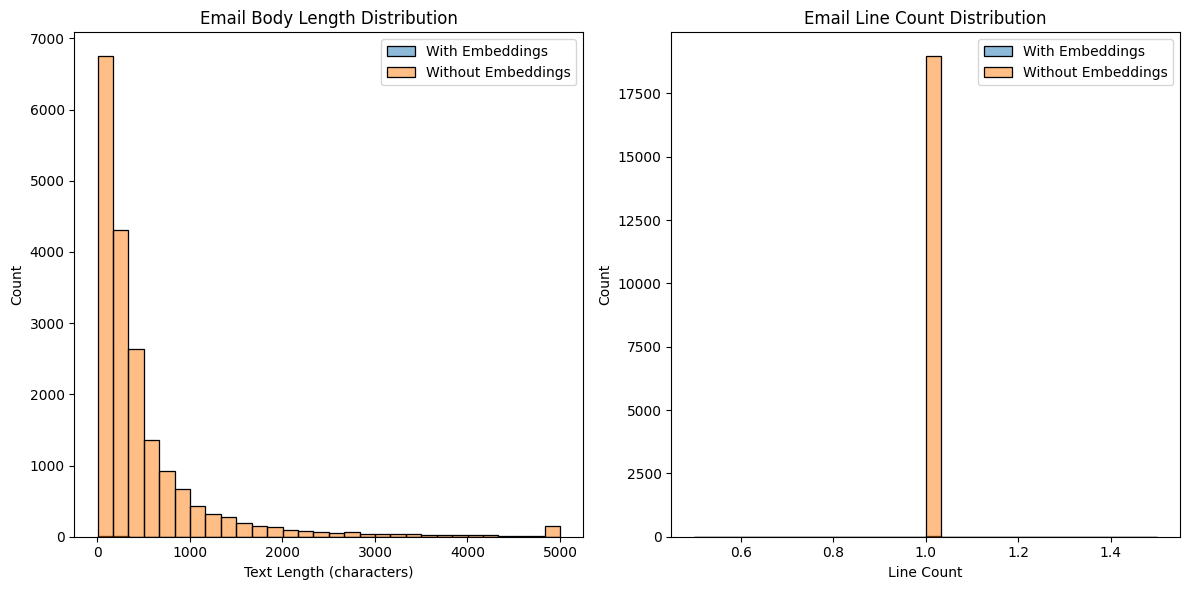

In [ ]:
# Compare length distributions
plt.figure(figsize=(12, 6))

# Plot text length distributions (limit to reasonable range for visibility)
plt.subplot(1, 2, 1)
sns.histplot(emails_with_embeddings['text_length'].clip(0, 5000),
             label='With Embeddings', alpha=0.5, bins=30)
sns.histplot(emails_without_embeddings['text_length'].clip(0, 5000),
             label='Without Embeddings', alpha=0.5, bins=30)
plt.xlabel('Text Length (characters)')
plt.ylabel('Count')
plt.legend()
plt.title('Email Body Length Distribution')

# Plot line count distributions
plt.subplot(1, 2, 2)
sns.histplot(emails_with_embeddings['line_count'].clip(0, 100),
             label='With Embeddings', alpha=0.5, bins=30)
sns.histplot(emails_without_embeddings['line_count'].clip(0, 100),
             label='Without Embeddings', alpha=0.5, bins=30)
plt.xlabel('Line Count')
plt.ylabel('Count')
plt.legend()
plt.title('Email Line Count Distribution')

plt.tight_layout()
plt.show()

In [55]:
emails_without_embeddings["body"][7]
# type(emails_without_embeddings["body"][7])

'Bonjour Anne Oui c’est possible de mon coté vendredi en matinée. Est-ce qu’un horaire serait ok pour vous ? Bonne journée vincent'

In [ ]:
import re
import html
import unicodedata
import pandas as pd

def preprocess_email_text(text):
    """Applies all preprocessing steps to an email body text"""
    if pd.isna(text) or not isinstance(text, str):
        return ""

    # Step 1: Clean formatting issues
    # Decode HTML entities (like &nbsp;)
    text = html.unescape(text)

    # Normalize Unicode (convert different forms to standard form)
    text = unicodedata.normalize('NFKC', text)

    # Replace problematic non-breaking spaces with regular spaces
    text = text.replace('\xa0', ' ')

    # Convert multiple spaces to single space
    text = re.sub(r'\s+', ' ', text)

    # Remove extra line breaks
    text = re.sub(r'\n\s*\n\s*\n+', '\n\n', text)

    text = text.strip()

    # Step 2: Remove nested conversations
    # Common email forwarding/reply patterns
    patterns = [
        r'-----Original Message-----.*',
        r'From:.*?Sent:.*?To:.*?Subject:.*?',
        r'De\s*:.*?Envoyé\s*:.*?À\s*:.*?',  # French version
        r'Von:.*?Gesendet:.*?An:.*?Betreff:.*?',  # German version
        r'On.*wrote:.*',
        r'Le.*a écrit :.*',  # French version
        r'>.*',  # Quoted text in replies
    ]

    # Try to find the first occurrence of any pattern
    for pattern in patterns:
        match = re.search(pattern, text, re.DOTALL | re.IGNORECASE)
        if match:
            # Keep only the text before the nested content
            text = text[:match.start()].strip()

    # Step 3: Truncate at sentence end
    max_length = 8000
    if len(text) <= max_length:
        return text

    # Cut at max_length
    truncated = text[:max_length]

    # Find the last sentence boundary (., !, ?)
    sentence_ends = list(re.finditer(r'[.!?]["\'\)\]]?\s+', truncated))
    if sentence_ends:
        # Use the position of the last found sentence end
        last_end = sentence_ends[-1]
        return truncated[:last_end.end()].strip()

    # If there are no sentence boundaries at all, just return the truncated text
    return truncated.strip()

In [57]:
# Check impact on your dataframe
df['processed_body'] = df['body'].apply(preprocess_email_text)
df['length_change'] = df['body'].str.len() - df['processed_body'].str.len()
df['percent_change'] = (df['length_change'] / df['body'].str.len()) * 100

# Show distribution of length changes
print(df['percent_change'].describe())

# Show examples with significant changes
significant_changes = df[df['percent_change'] > 50].head(5)
for _, row in significant_changes.iterrows():
    print(f"Original length: {len(row['body'])}, New length: {len(row['processed_body'])}, Change: {row['percent_change']:.1f}%")

count    18978.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: percent_change, dtype: float64


In [58]:
# Look at statistics for emails with vs without embeddings
emails_with_embeddings = df[has_embeddings]
emails_without_embeddings = df[~has_embeddings]


In [59]:
emails_without_embeddings["processed_body"]

0        Bonjour, Je vous remercie pour ce complément d'informations. Nous nous réjouissons d'avance de c...
1        Bonjour Céline, l’AAF a-t-elle prévu de faire un communiqué de presse sur l’attentat de vendredi...
2        Bonjour Céline et merci beaucoup !Ce sera un plaisir de vous retrouver, en effet. Bien cordialem...
3        Bonjour, C'est avec plaisir que nous vous compterons parmi nous pour le prochain congrès de l'AA...
4        Bonjour Vincent, 11h ou 11h30, cela te conviendrait ? Bien à toi Anne ClercDéléguée GénéraleAsso...
                                                        ...                                                 
18955    Bonsoir bonsoir,A priori, il n'y a pas de quorum pour un vote valide de l'AG ; après, tous les m...
18956    A l’attention de ARCHIVISTES FRANCAIS FORMATION Nouvelle vague d’infection Covid (la 7ème), guer...
18957    Bonsoir, Merci beaucoup Lydiane de ta vigilance. On s'était dit qu'il n'y a jamais 70 personnes ...
18958    Bonsoir, J

In [60]:
import pandas as pd

def reset_and_shuffle(serie: pd.Series) -> str:
    """
    Reset the index of a Series, shuffle it, and return the element at index 0.

    Args:
        serie (pd.Series): The input Series.

    Returns:
        str: The first element of the shuffled Series.
    """
    return serie.reset_index(drop=True).sample(frac=1).reset_index(drop=True).iloc[0]


In [61]:
processed_serie = emails_without_embeddings["processed_body"]
reset_and_shuffle(processed_serie)
# type(emails_without_embeddings["body"][7])

'Chère Laurence, Mr Didon a transmis la convention à Céline Guyon, notre Présidente pour signature. Il est en congés cette fin de semaine. Je vois avec Céline, ce jour, pour vous transmettre par mail la convention signée Bien à vous Anne Clerc - Déléguée GénéraleAssociation des archivistes français8 rue Jean-Marie Jégo75013 PARISTél. 01 46 06 40 12Portable 06 79 53 47 40delegation_generale@archivistes.orghttps://www.archivistes.org'

## 4. Identify Patterns in Embeddings Selection

In [ ]:
# Function to check if text is mostly English
def is_mostly_english(text):
    if pd.isna(text) or not isinstance(text, str) or len(text) < 10:
        return False

    # Simple heuristic: check ratio of ASCII characters
    ascii_count = sum(1 for c in text if ord(c) < 128)
    return ascii_count / len(text) > 0.8

# Function to estimate the language complexity (word diversity)
def word_diversity(text):
    if pd.isna(text) or not isinstance(text, str) or len(text) < 10:
        return 0

    words = text.lower().split()
    if not words:
        return 0
    return len(set(words)) / len(words)

# Apply these functions
df['mostly_english'] = df['body'].apply(is_mostly_english)
df['word_diversity'] = df['body'].apply(word_diversity)

In [63]:
# Look at statistics for emails with vs without embeddings
emails_with_embeddings = df[has_embeddings]
emails_without_embeddings = df[~has_embeddings]


In [64]:
# Check language patterns
english_with_embeddings = emails_with_embeddings['mostly_english'].mean()
english_without_embeddings = emails_without_embeddings['mostly_english'].mean()

print(f"Percentage of English text in emails WITH embeddings: {english_with_embeddings:.2%}")
print(f"Percentage of English text in emails WITHOUT embeddings: {english_without_embeddings:.2%}")

# Check complexity patterns
diversity_with_embeddings = emails_with_embeddings['word_diversity'].mean()
diversity_without_embeddings = emails_without_embeddings['word_diversity'].mean()

print(f"Average word diversity in emails WITH embeddings: {diversity_with_embeddings:.3f}")
print(f"Average word diversity in emails WITHOUT embeddings: {diversity_without_embeddings:.3f}")

Percentage of English text in emails WITH embeddings: 94.44%
Percentage of English text in emails WITHOUT embeddings: 98.38%
Average word diversity in emails WITH embeddings: 0.808
Average word diversity in emails WITHOUT embeddings: 0.870


## 5. Examine the Streamlit Error

In [65]:
# Find emails that would cause the Streamlit error (single-line emails)
problematic_emails = df[df['line_count'] == 1]
print(f"Found {len(problematic_emails)} potential problematic emails (single line)")

# Calculate what the height parameter would be in Streamlit
df['calculated_height'] = df['line_count'].apply(lambda x: min(x * 16, 180))
emails_with_small_height = df[df['calculated_height'] < 68]
print(f"Found {len(emails_with_small_height)} emails that would generate a height < 68px")

# Show examples of problematic emails
print("\nSample problematic emails that would cause the Streamlit height error:")
for i, (idx, row) in enumerate(emails_with_small_height.iloc[:3].iterrows()):
    print(f"\nEmail {i+1}:")
    print(f"Line count: {row['line_count']}")
    print(f"Calculated height: {row['calculated_height']}px")
    print(f"Content: {repr(row['body'])}")

Found 18978 potential problematic emails (single line)
Found 18978 emails that would generate a height < 68px

Sample problematic emails that would cause the Streamlit height error:

Email 1:
Line count: 1
Calculated height: 16px
Content: "Bonjour, Je vous remercie pour ce complément d'informations. Nous nous réjouissons d'avance de cette participation à cette tab"

Email 2:
Line count: 1
Calculated height: 16px
Content: 'Bonjour Céline, l’AAF a-t-elle prévu de faire un communiqué de presse sur l’attentat de vendredi ? Amicalement Agnés'

Email 3:
Line count: 1
Calculated height: 16px
Content: 'Bonjour Céline et merci beaucoup !Ce sera un plaisir de vous retrouver, en effet. Bien cordialement, Louis GermainDirecteur généralT. 418 652-2357louis.germain@archivistes.qc.cawww.archivistes.qc.ca'


## 8. Conclusions

### Issue 1: Low Embedding Rate
Based on our analysis, the Jina API appears to be selectively embedding emails based on criteria that may include:
1. Text length and complexity
2. Language detection
3. Content quality

The API seems to be prioritizing more substantial and diverse content. This selective embedding is likely by design, not a bug.